[Autoregressive Image models](https://arxiv.org/pdf/2401.08541.pdf) - The counterparts to LLM in the image domain were introduced by Apple. Though openAI launched `iGPT` like 2 years before, the autoregression was not explored at full scale from then. In this paper, the authors shows that the avg accuracy on downstream tasks on a set of image datasets linearly increases with data and parameters.

AIM introduces two concepts. 
- For pretraining: AIM introduced something called `PrefixLM` which allows to do bidirectional attn during downstream task and do pre-training without any change in architecture. 
- For downstream: `Attentive Probing`

In this blog we will understand what is `Casual Masking` in `self-attention` and then see how `PrefixLM` is designed.

Before reading this blog I highly recommend going through this [nanoGPT video tutorial](https://www.youtube.com/watch?v=kCc8FmEb1nY)

 Lets load the required libraries first.

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import fastcore.all as fc
from PIL import Image
from functools import partial
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

> Lets create an image of size 224x224 with a patch size of 32

In [ ]:
img_size = 224
patch_size = 32

## load and visualize an image

we load and use `coco val` data. For this blog purpose, u can pick up any image of your choice from the internet.

In [ ]:
imgs = fc.L(fc.Path("../coco/val2017/").glob("*.jpg"))
imgs

(#5000) [Path('../coco/val2017/000000182611.jpg'),Path('../coco/val2017/000000335177.jpg'),Path('../coco/val2017/000000278705.jpg'),Path('../coco/val2017/000000463618.jpg'),Path('../coco/val2017/000000568981.jpg'),Path('../coco/val2017/000000092416.jpg'),Path('../coco/val2017/000000173830.jpg'),Path('../coco/val2017/000000476215.jpg'),Path('../coco/val2017/000000479126.jpg'),Path('../coco/val2017/000000570664.jpg')...]

> The following are the standard transforms mentioned in the paper.

In [ ]:
def transforms():
    return Compose([RandomResizedCrop(size=224, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2), 
                    RandomHorizontalFlip(p=0.5), 
                    ToTensor()])

In [ ]:
def load_img(img_loc, transforms):
    img = Image.open(img_loc)
    return transforms(img)

load_img = partial(load_img, transforms=transforms())

In [ ]:
img = load_img(imgs[1])
img.shape

torch.Size([3, 224, 224])

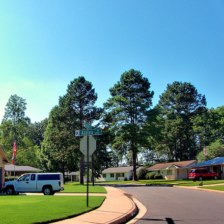

In [ ]:
ToPILImage()(img)

## How input data is set up for auto-regression?
An image is split into a grid of K non-overlapping patches which collectively form a sequence of tokens. since the image size is (224, 224) and patch size is (32, 32) we will get a total of 7x7 =49 patches. 

In [ ]:
imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
imgp.shape

torch.Size([49, 3, 32, 32])

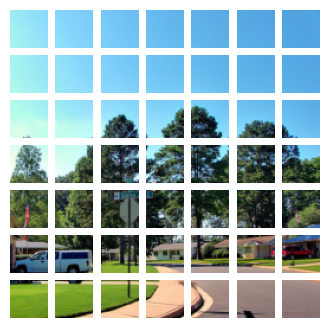

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(imgp):
    ax.flat[n].imshow(ToPILImage()(i))
    ax.flat[n].axis("off")
plt.show()

Autoregression is setup in such a way that 
- for token 1 -> token 2 is the prediction 
- for token 1, 2 -> token 3 is the prediction 
- for token 1, 2, 3 -> token 4 is the prediction
- for token 1, 2, 3, ... n-1 -> token n is the prediction.

so input tokens will be upto [0, n-1] and output tokens will be [1, n]

In [ ]:
x = imgp[:-1]
y = imgp[1:]
x.shape, y.shape

(torch.Size([48, 3, 32, 32]), torch.Size([48, 3, 32, 32]))

> As an example, so if we have tokens till [0, 24], the 25th token is the prediction. In the below image, the RGB images are input tokens and token highlighted with red border is the prediction token for those set of input tokens. 

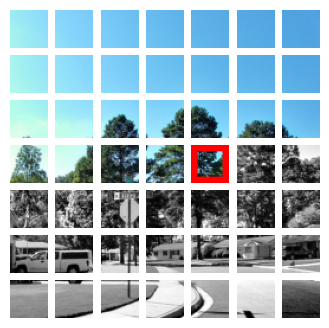

In [ ]:
prediction = 25
fig, ax = plt.subplots(figsize=(4, 4), nrows=7, ncols=7)
for n, i in enumerate(imgp):
    token = ToPILImage()(i)
    if n <prediction:
        ax.flat[n].imshow(token)
    elif n == prediction:
        new_size = (48, 48)
        new_im=np.zeros((48, 48, 3))
        new_im[:, :, 0] = 255
        new_im = Image.fromarray(np.uint8(new_im))
        box = tuple((n - o) // 2 for n, o in zip(new_size, token.size))
        new_im.paste(token, box)
        ax.flat[n].imshow(new_im, cmap="hsv")
    else:
        ax.flat[n].imshow(token.convert("L"), cmap="gray")
    ax.flat[n].axis("off")
plt.show()

## How self-attention is applied on input tokens. 
Attention is nothing but a cosine similarity between two matrices. but while doing token level prediction, the network should see only those tokens which are up till then but not tokens post that. For example for prediction of token 25 we should use only tokens from 1 to 24 and discard tokens from 26 to 49(we have 49 tokens in the example we took). We will next see how this can be achieved. 

In the above we got `x shape as (48, 3, 32, 32) and y shape as  (48, 3, 32, 32]`. The y is the output we need or ground truth here, but we will directly convert the raw image to tokens using `PatchEmbed` and then discard the final token.

Do `pip install pip install git+https://git@github.com/apple/ml-aim.git` first and import necessary functions.

In [ ]:
from aim.torch.layers import PatchEmbed, LayerNorm, SinCosPosEmbed, MLP

In [ ]:
pe = PatchEmbed(img_size=img_size, patch_size=patch_size, norm_layer=LayerNorm)
pe

PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
)

In [ ]:
tokens = pe(img.unsqueeze(0))
tokens.shape #

torch.Size([1, 49, 768])

> In AIM, they have not used class tokens. We will add sincos positional embeddings

In [ ]:
scpe = SinCosPosEmbed(cls_token=False)
scpe

SinCosPosEmbed()

In [ ]:
pe = scpe(h=7, w=7, embed_dim=768)
pe.shape

torch.Size([49, 768])

> Add these positional embeddings to input tokens. 

In [ ]:
tokens = tokens+pe[None]
tokens.shape

torch.Size([1, 49, 768])

> we will remove the last token now as it doesn't have any Gt

In [ ]:
tokens = tokens[:, :48, :]
tokens.shape

torch.Size([1, 48, 768])

## Self Attention 
A lot of things happen inside a Transformer block. but in simple terms we first 
- normalize the input 
- Apply attention 
- Apply MLP

### normalization 
In transformers block, we need layer normalization. Layer normalization is usually done at token level so there is no information exchange between tokens.

In [ ]:
token_norms = LayerNorm(768)(tokens)
token_norms.mean((0, 2)),token_norms.var((0, 2))

(tensor([ 0.0000e+00, -1.7385e-08, -2.1110e-08, -2.4835e-09,  1.8626e-09,
          1.2418e-09,  3.7253e-08,  2.3594e-08,  1.0555e-08, -9.9341e-09,
          1.2418e-08, -2.0800e-08,  1.9247e-08, -1.1797e-08,  6.7055e-08,
          1.1176e-08,  3.6632e-08, -3.6632e-08, -5.2465e-08, -2.4835e-08,
         -1.0245e-08, -1.5212e-08,  1.7385e-08, -3.3528e-08, -2.1110e-08,
         -2.2352e-08,  1.3039e-08,  1.8626e-08, -6.5193e-09, -2.7319e-08,
         -1.4280e-08,  2.1110e-08, -1.5522e-08,  3.1044e-09,  2.2041e-08,
         -9.3132e-10,  9.3132e-09, -2.8871e-08, -1.8626e-08,  3.1044e-09,
          2.6077e-08,  1.4901e-08,  1.1797e-08, -8.0715e-09,  4.8429e-08,
         -1.5522e-09, -4.1910e-08, -1.8316e-08], grad_fn=<MeanBackward1>),
 tensor([1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013,
         1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013,
         1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013, 1.0013,
         1.0013,

### MLP 
In MLP also, each token [row] is multiplied with each [column] of the MLP weight matrix. so there is no interaction between the tokens and this essentially means that we can use this network to process each token separately

In [ ]:
mlp = MLP(
    in_features=768,
    hidden_features=768*4,
    act_layer=nn.GELU,
    drop=0.2,
    use_bias=False
)
mlp

MLP(
  (fc1): Linear(in_features=768, out_features=3072, bias=False)
  (act): GELU(approximate='none')
  (fc2): Linear(in_features=3072, out_features=768, bias=False)
  (drop): Dropout(p=0.2, inplace=False)
)

In [ ]:
mlp(token_norms).shape

torch.Size([1, 48, 768])

### Casual Attention 
Attention is the only place where we calculate the interaction between tokens using quries, keys and values. but for auto-regression, the past tokens should not learn from the future. for example, if we are predicting token 5, we should only use token 1, 2, 3, 4 and discard all the tokens from 5. In Transformers this is achieved using something called **casual attention**. we will learn and understand what it is in this section. To simplify the understanding we will use only single head and not use multiple heads. 

In attention, the following steps happen
- use mlp, to get key, query and values. 
- Apply self-attention between queries and keys (essentially a dot product). we get a matrix of qk (49x49). scale the values
- apply softmax
- self attention between qk and v.

In [ ]:
# lets see a single head perform self-attention
B, T, C = token_norms.shape
head_size = 768
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(token_norms)
q = query(token_norms)
v = value(token_norms)
scale_factor = 1 / math.sqrt(q.size(-1)) 
qk = q@k.transpose(-2, -1) * scale_factor #(B, T, 16) @ (B, 16, T) --. B, T, T
qk.shape

torch.Size([1, 48, 48])

> This matrix will essentially tell the interaction strength between each token. 

`values` will aggregate the information for each token from all other tokens. The row1 of qk is multiplied with all the columns of `values`, but token1 should only have information from token1 and discard all others. Similarly token2, should have qk values only from token1 and token2 and discard all other values. if you follow this along, we ideally want to remove all the values from upper traingle of the matrix. 

In the attention paper, instead of removing, they replace it with `-inf`. This is because when softmax is applied, these extremely small values will become zero and hence will have no effect.

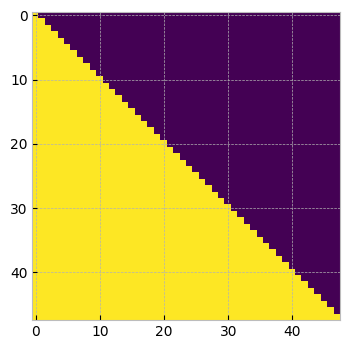

In [ ]:
tril = torch.tril(torch.ones(T,T))
plt.figure(figsize=(4, 4))
plt.imshow(tril.numpy())
plt.show()

In [ ]:
qk = qk.masked_fill(tril==0, float("-inf"))
qk[0]

tensor([[0.3354,   -inf,   -inf,  ...,   -inf,   -inf,   -inf],
        [0.3412, 0.3489,   -inf,  ...,   -inf,   -inf,   -inf],
        [0.3663, 0.3698, 0.3422,  ...,   -inf,   -inf,   -inf],
        ...,
        [0.9337, 0.9750, 0.9633,  ..., 0.8890,   -inf,   -inf],
        [0.8462, 0.8887, 0.8814,  ..., 0.8392, 0.7537,   -inf],
        [0.6571, 0.6705, 0.6382,  ..., 0.5844, 0.5688, 0.6007]],
       grad_fn=<SelectBackward0>)

In [ ]:
qk = torch.softmax(qk, dim=-1)
qk[0]

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4981, 0.5019, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3356, 0.3368, 0.3276,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0216, 0.0225, 0.0222,  ..., 0.0206, 0.0000, 0.0000],
        [0.0211, 0.0220, 0.0219,  ..., 0.0210, 0.0192, 0.0000],
        [0.0211, 0.0214, 0.0207,  ..., 0.0196, 0.0193, 0.0199]],
       grad_fn=<SelectBackward0>)

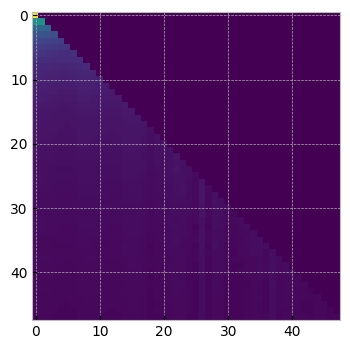

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(qk.detach().numpy()[0])
plt.show()

now when we multiply with values, only tokens till to that point share information.

In [ ]:
attn = qk@v
attn.shape

torch.Size([1, 48, 768])

This attention is propogated through a linear & drop out layer. 

In [ ]:
proj = nn.Linear(768, 768, bias=False)
tokens = proj(attn)
tokens.shape

torch.Size([1, 48, 768])

There are some skip connections and other MLP blocks inside the `Transformers` for stabilizing the training but this is essentially what happens in `Transformer` block

## PrefixLM

From the above we see that while AutoRegressive Pre-training, we apply casual masking and while fine-tuning, if we remove casual mask, we are doing bidirectional self-attention. This descrpency has led to sub-par perfromances when fine-tuning. 

Inorder to solve this the author in the paper suggest to consider the initial tokens of the sequence, referred to as the prefix, as a context for predicting the remaining patches. So bidirectional self-attention is applied for the initial K tokens and the predictions for these are not considered. for remaining tokens, we will perform casual mask as discussed above. Lets see how this is done. 

Suppose we will consider `k=25`. we will get the mask for `N` patches

In [ ]:
K = 25
mask = torch.ones(B, tokens.shape[1]).to(torch.bool)
mask[:, :K] = 0
print(mask.shape)
mask

torch.Size([1, 48])


tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True]])

In [ ]:
prefix_mask = (~mask).unsqueeze(1).expand(-1, tokens.shape[1], -1).bool()
print(prefix_mask.shape)
prefix_mask[0]

torch.Size([1, 48, 48])


tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

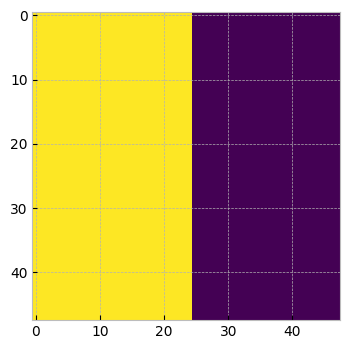

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(prefix_mask.numpy()[0])
plt.show()

> we will now define the `attn_mask` with the upper training values being zero

torch.Size([1, 48, 48])


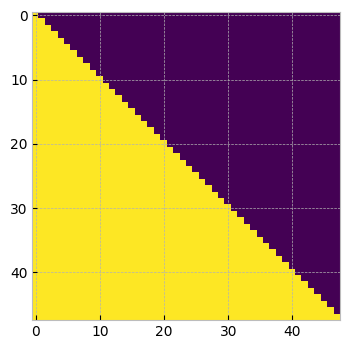

In [ ]:
attn_mask = torch.ones(1, tokens.shape[1], tokens.shape[1], dtype=torch.bool).tril(diagonal=0)
print(attn_mask.shape)
plt.figure(figsize=(4, 4))
plt.imshow(attn_mask.numpy()[0])
plt.show()

torch.Size([1, 48, 48])


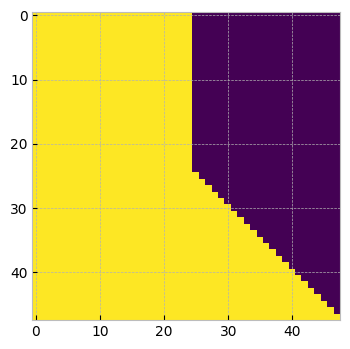

In [ ]:
attn_mask = torch.logical_or(attn_mask, prefix_mask)
print(attn_mask.shape)
plt.figure(figsize=(4, 4))
plt.imshow(attn_mask.numpy()[0])
plt.show()

the above `attn_mask` will make sure that for the first 25 tokens we will do bidirectional self-attention and for the remaining tokens `causual_masking` is applied. 

In [ ]:
qk = qk.masked_fill(attn_mask==0, float("-inf"))
print(qk.shape)
qk[0]

torch.Size([1, 48, 48])


tensor([[1.0000, 0.0000, 0.0000,  ...,   -inf,   -inf,   -inf],
        [0.4981, 0.5019, 0.0000,  ...,   -inf,   -inf,   -inf],
        [0.3356, 0.3368, 0.3276,  ...,   -inf,   -inf,   -inf],
        ...,
        [0.0216, 0.0225, 0.0222,  ..., 0.0206,   -inf,   -inf],
        [0.0211, 0.0220, 0.0219,  ..., 0.0210, 0.0192,   -inf],
        [0.0211, 0.0214, 0.0207,  ..., 0.0196, 0.0193, 0.0199]],
       grad_fn=<SelectBackward0>)

In [ ]:
qk = torch.softmax(qk, dim=-1)
qk[0]

tensor([[0.1017, 0.0374, 0.0374,  ..., 0.0000, 0.0000, 0.0000],
        [0.0626, 0.0628, 0.0380,  ..., 0.0000, 0.0000, 0.0000],
        [0.0534, 0.0535, 0.0530,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0217, 0.0218, 0.0217,  ..., 0.0217, 0.0000, 0.0000],
        [0.0213, 0.0213, 0.0213,  ..., 0.0213, 0.0212, 0.0000],
        [0.0208, 0.0208, 0.0208,  ..., 0.0208, 0.0208, 0.0208]],
       grad_fn=<SelectBackward0>)

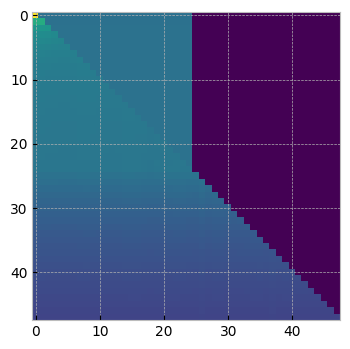

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(qk.detach().numpy()[0])
plt.show()

In [ ]:
attn = qk@v
print(attn.shape[0])
attn[0]

1


tensor([[ 0.9102,  0.2899, -0.4562,  ..., -0.0554,  0.2982,  1.4015],
        [ 0.9125,  0.2941, -0.4578,  ..., -0.0558,  0.2949,  1.4056],
        [ 0.9135,  0.2954, -0.4594,  ..., -0.0551,  0.2924,  1.4080],
        ...,
        [ 0.8787,  0.3149, -0.5150,  ..., -0.0829,  0.1735,  1.3375],
        [ 0.8820,  0.3152, -0.5220,  ..., -0.0798,  0.1744,  1.3371],
        [ 0.8860,  0.3186, -0.5214,  ..., -0.0759,  0.1729,  1.3319]],
       grad_fn=<SelectBackward0>)

In the context of AIM, they have not mentioned what value of K to use. but I am considering we can select a random number at each iteration. 

In the next blog we will see how to pre-train `AIM` using CIFAR data